In [1]:
from openai import OpenAI
from langchain_openai import ChatOpenAI

# llm_client = OpenAI(
llm_client = ChatOpenAI(
    base_url="http://localhost:8001/v1",
    api_key="dummy",
    model="/home/yhj2263/llama/models/Llama-3.1-8B-Instruct"
)

In [35]:
from langchain_core.pydantic_v1 import BaseModel, Field


class GetWeather(BaseModel):
    '''Get the current weather in a given location'''

    location: str = Field(
        ..., description="The city and state, e.g. San Francisco, CA"
    )


class GetPopulation(BaseModel):
    '''Get the current population in a given location'''

    location: str = Field(
        ..., description="The city and state, e.g. San Francisco, CA"
    )


llm_with_tools = llm_client.bind_tools(
    [GetWeather, GetPopulation]
)

In [36]:
ai_msg = llm_with_tools.invoke(
    "Which city is hotter today and which is bigger: LA or NY?"
)
ai_msg.tool_calls

[{'name': 'GetWeather',
  'args': {'location': 'Los Angeles, CA'},
  'id': 'chatcmpl-tool-5959e912caae46859bd77da5c26f62a5',
  'type': 'tool_call'},
 {'name': 'GetWeather',
  'args': {'location': 'New York, NY'},
  'id': 'chatcmpl-tool-c5a9efdbbef1495f84785cbfe7f71ab9',
  'type': 'tool_call'},
 {'name': 'GetPopulation',
  'args': {'location': 'Los Angeles, CA'},
  'id': 'chatcmpl-tool-c89ac6e843b14724982ff5f1478fb7d7',
  'type': 'tool_call'},
 {'name': 'GetPopulation',
  'args': {'location': 'New York, NY'},
  'id': 'chatcmpl-tool-8ae95126eb6f4736a07f35fa56611c3b',
  'type': 'tool_call'}]

In [37]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [38]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

In [2]:
from typing import Annotated

from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


@tool
def get_time_series_data(start_date, end_date) -> str:
    """Get time series data."""
    # generate random time series data between start_date and end_date
    df = pd.DataFrame({
        'date': pd.date_range(start_date, end_date),
        'value': np.random.randn(10)
    })
    data_dict = df.to_dict(orient="list")
    json_data = json.dumps(data_dict, default=str)
    return json_data

@tool
def plot_time_series_data(data: str) -> str:
    """Plot time series data."""
    # plot time series data
    json_data = json.loads(data)
    df = pd.DataFrame(json_data)
    df.plot(x='date', y='value')
    plt.show()
    # fig.show()
    return "Time series data plotted." 


tools = [get_time_series_data, plot_time_series_data]
llm_with_tools = llm_client.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert(len(message.tool_calls) <= 1)
    return {"messages": [message]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

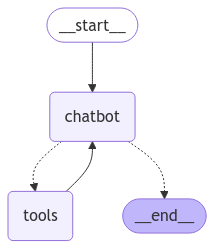

In [3]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
%matplotlib inline

# user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
user_input = "I want a time series data between 2021-01-01 and 2021-01-10, don't plot the data"
# user_input = "Please also plot the data"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I want a time series data between 2021-01-01 and 2021-01-10, don't plot the data
================================== Ai Message ==================================
Tool Calls:
  get_time_series_data (chatcmpl-tool-f66872b8ce8d477bb58c27bbb465728b)
 Call ID: chatcmpl-tool-f66872b8ce8d477bb58c27bbb465728b
  Args:
    start_date: 2021-01-01
    end_date: 2021-01-10
================================= Tool Message =================================
Name: get_time_series_data

{"date": ["2021-01-01 00:00:00", "2021-01-02 00:00:00", "2021-01-03 00:00:00", "2021-01-04 00:00:00", "2021-01-05 00:00:00", "2021-01-06 00:00:00", "2021-01-07 00:00:00", "2021-01-08 00:00:00", "2021-01-09 00:00:00", "2021-01-10 00:00:00"], "value": [0.05816119292223121, 1.1796014193653515, -0.4147295141636129, -0.4704793292634438, 1.1096771575764766, 0.01094088970442896, -1.3664786739292136, -1.1347325517254794, 0.778115813099336, 0.40065457

================================ Human Message =================================

I want a time series data between 2021-01-01 and 2021-01-10, please also plot the data
================================== Ai Message ==================================
Tool Calls:
  get_time_series_data (chatcmpl-tool-bc941ad40c054f059bf3b40a6b0e853e)
 Call ID: chatcmpl-tool-bc941ad40c054f059bf3b40a6b0e853e
  Args:
    start_date: 2021-01-01
    end_date: 2021-01-10
================================= Tool Message =================================
Name: get_time_series_data

{"date": ["2021-01-01 00:00:00", "2021-01-02 00:00:00", "2021-01-03 00:00:00", "2021-01-04 00:00:00", "2021-01-05 00:00:00", "2021-01-06 00:00:00", "2021-01-07 00:00:00", "2021-01-08 00:00:00", "2021-01-09 00:00:00", "2021-01-10 00:00:00"], "value": [-1.207794628927208, 0.41861276391097824, -0.033467177480204995, 1.84895827096554, 1.405048390640455, 0.08337657228589866, 1.321202519454162, -0.5038330152173371, -1.2780582199623562, -0.621

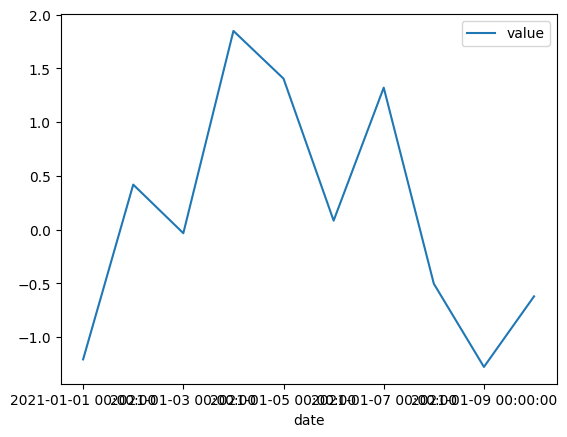

================================= Tool Message =================================
Name: plot_time_series_data

Time series data plotted.
================================== Ai Message ==================================

The time series data between 2021-01-01 and 2021-01-10 has been retrieved and plotted.


In [7]:
user_input = "I want a time series data between 2021-01-01 and 2021-01-10, please also plot the data"
# user_input = "Please also plot the data"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()